In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

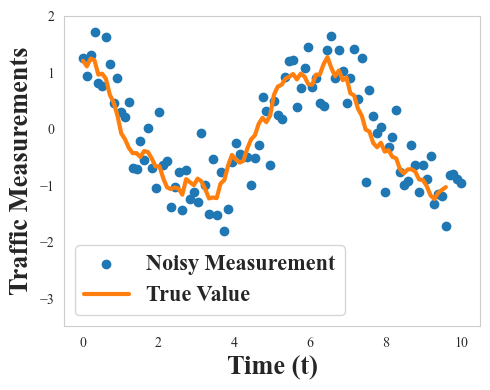

In [61]:
plt.rcParams['font.family'] = 'Times New Roman'
# Generate some noisy data
np.random.seed(42)  # Set seed for reproducibility
x = np.linspace(0, 10, 100)
y_noisy = np.cos(x) + 0.5 * np.random.normal(size=len(x))

# Optionally, you can add a denoising step here
# For example, using a moving average for simplicity
window_size = 5
y_denoised = np.convolve(y_noisy, np.ones(window_size)/window_size, mode='valid')

# Plot the noisy data
fig = plt.figure(figsize=(5, 4))
plt.subplot(1, 1, 1)
plt.scatter(x, y_noisy, label='Noisy Measurement', marker='o')
plt.plot(x[:len(y_denoised)], y_denoised, label='True Value', color='#ff7f0e', linewidth=3)

#plt.title('Denoised Data', fontsize = 16)
plt.xlabel('Time (t)', fontsize = 19, weight = 'bold')
plt.ylabel('Traffic Measurements', fontsize = 19, weight = 'bold')
plt.legend(loc='lower left', prop={'weight':'bold', 'size': 16})
plt.ylim(-3.5, 2)

plt.tight_layout()
plt.grid(False)
plt.show()
fig.savefig("Figures/Manuscript/Noisy_Denoise.png", dpi = 300, bbox_inches='tight')

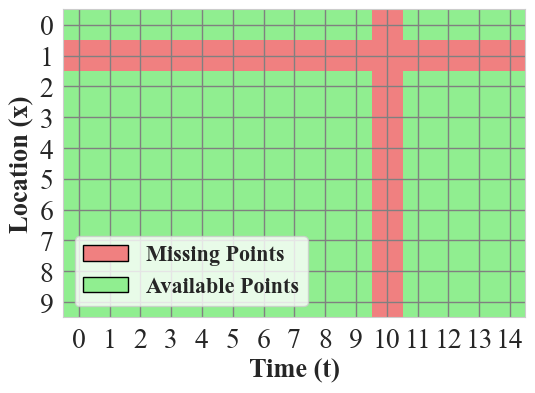

In [62]:
# Create a 5x5 grid
grid_size_1 = 10
grid_size_2 = 15
grid = np.zeros((grid_size_1, grid_size_2))

# Define the indices of sparse nodes
sparse_nodes = [(1, 0), (1,1), (1, 2), (1, 3), (1, 4),(1, 5),(1, 6),(1, 7),(1, 8),(1, 9),(1, 10),(1, 11),(1, 12),(1, 13),(1, 14),
                (0,10), (1,10), (2,10), (3,10), (4,10), (5,10), (6,10), (7,10), (8,10), (9,10)]

# Mark sparse nodes as 1 (green nodes)
for node in sparse_nodes:
    grid[node[0], node[1]] = 1

colors = ['lightgreen', 'lightcoral']
cmap = ListedColormap(colors)
# Plot the grid
fig = plt.figure(figsize=(6, 4))
plt.imshow(grid, cmap=cmap, interpolation='nearest')

# Customize the plot
#plt.title('5x5 Grid with Spatiotemporal Sparsity')
plt.xticks(np.arange(0, grid_size_2, 1), fontsize = 20)
plt.yticks(np.arange(0, grid_size_1, 1), fontsize = 20)
plt.xlabel('Time (t)', fontsize = 19, weight = 'bold')
plt.ylabel('Location (x)', fontsize = 19, weight = 'bold')
plt.grid(color='gray', linestyle='-', linewidth=1)
legend_elements = [Patch(facecolor='lightcoral', edgecolor='black', label='Missing Points'),
                   Patch(facecolor='lightgreen', edgecolor='black', label='Available Points')]
# Add legend
plt.legend(handles=legend_elements, prop={'weight':'bold', 'size': 16}, loc='lower left')
plt.show()
fig.savefig("Figures/Manuscript/Sparsity.png", dpi = 300, bbox_inches='tight')

In [4]:
import torch
import pickle
import io
#from data_parser import data_loader_full
import pandas as pd

In [5]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Archive_Analysis_Results/Model_1_I605N/Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [6]:
def data_loader_full():
    occupancy = pd.read_csv('Data_Clean/I_605_N_1mile/Occupancy_all_Long.csv')
    # Convert occupancy to percentage by *100
    occupancy['Occupancy'] *= 100
    flow = pd.read_csv('Data_Clean/Flow_all_Long.csv')
    speed = pd.read_csv('Data_Clean/Speed_all_Long.csv')

    occupancy = occupancy[occupancy['TimeStep'] < 289].values
    flow = flow[flow['TimeStep'] < 289].values
    speed = speed[speed['TimeStep'] < 289].values

    return occupancy, flow, speed

In [7]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)
pred_k_t = pred['k_t'].to(torch.device('cpu'))
pred_k_t_predict = pred['k_t_predict'].to(torch.device('cpu'))
k_t = torch.cat((X_occu_all, pred_k_t), dim=1).detach().numpy()
k_t_predict = torch.cat((X_occu_all, pred_k_t_predict), dim=1).detach().numpy()
k_t = pd.DataFrame(k_t, columns = ['TimeStep','Station_Number','k_t'])
k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])

In [8]:
k_t['TimeStep'] = k_t['TimeStep'].astype(int)
k_t['Station_Number'] = k_t['Station_Number'].astype(int)

k_t_predict['TimeStep'] = k_t_predict['TimeStep'].astype(int)
k_t_predict['Station_Number'] = k_t_predict['Station_Number'].astype(int)

k_t_wide = k_t.pivot(index='Station_Number', columns='TimeStep', values='k_t')
k_t_predict_wide = k_t_predict.pivot(index='Station_Number', columns='TimeStep', values='k_t')

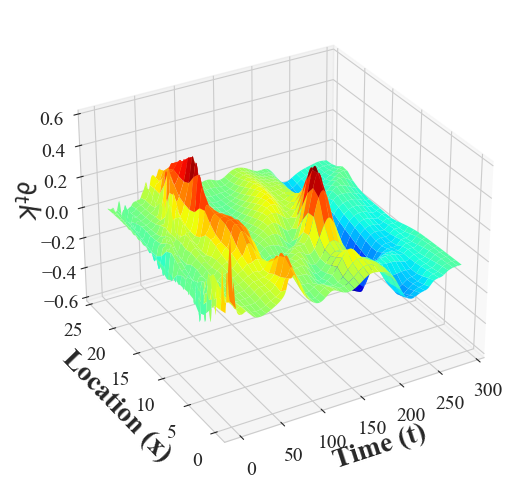

In [9]:
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Times New Roman'

loc, time = k_t_wide.index.values, k_t_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
kt_values = k_t_wide.values.T
kt_predict_values = k_t_predict_wide.values.T

ax1 = fig.add_subplot(111, projection='3d')

surf1 = ax1.plot_surface(time, loc, kt_values, cmap='jet', linewidth=0.02, alpha = 1, antialiased=True)
ax1.view_init(elev=30, azim=240)
ax1.set_zlim(-0.6, 0.6)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax1.set_xlabel('Time (t)', fontsize=20, weight = 'bold')
ax1.set_ylabel('Location (x)', fontsize=20, weight = 'bold')
ax1.set_zlabel(r'$\partial_tk$', fontsize=20, weight = 'bold')
#ax1.grid(False)
#ax1.set_axis_off()
#plt.tight_layout()
plt.show()
fig.savefig("Figures/Manuscript/k_t_predict_StudyFrame.png", dpi = 300, bbox_inches='tight')

In [117]:
import seaborn as sns

In [118]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [119]:
pred_occu = pred['occupancy_recon'].to(torch.device('cpu'))
pred_flow = pred['flow_recon'].to(torch.device('cpu'))
pred_speed = pred['speed_recon'].to(torch.device('cpu'))

pred_k_t = pred['k_t'].to(torch.device('cpu'))

pred_k_x = pred['k_x'].to(torch.device('cpu'))
pred_q_x = pred['q_x'].to(torch.device('cpu'))
pred_v_x = pred['v_x'].to(torch.device('cpu'))
pred_k_t_predict = pred['k_t_predict'].to(torch.device('cpu'))

pred_k_xx = pred['k_xx'].to(torch.device('cpu'))
pred_q_xx = pred['q_xx'].to(torch.device('cpu'))
pred_v_xx = pred['v_xx'].to(torch.device('cpu'))


In [120]:
occupancy_recon = torch.cat((X_occu_all, pred_occu), dim=1).detach().numpy()
flow_recon = torch.cat((X_occu_all, pred_flow), dim=1).detach().numpy()
speed_recon = torch.cat((X_occu_all, pred_speed), dim=1).detach().numpy()

k_t = torch.cat((X_occu_all, pred_k_t), dim=1).detach().numpy()
k_x = torch.cat((X_occu_all, pred_k_x), dim=1).detach().numpy()
q_x = torch.cat((X_occu_all, pred_q_x), dim=1).detach().numpy()
v_x = torch.cat((X_occu_all, pred_v_x), dim=1).detach().numpy()

k_xx = torch.cat((X_occu_all, pred_k_xx), dim=1).detach().numpy()
q_xx = torch.cat((X_occu_all, pred_q_xx), dim=1).detach().numpy()
v_xx = torch.cat((X_occu_all, pred_v_xx), dim=1).detach().numpy()

k_t_predict = torch.cat((X_occu_all, pred_k_t_predict), dim=1).detach().numpy()

occupancy_recon = pd.DataFrame(occupancy_recon, columns=['TimeStep', 'Station_Number', 'Occupancy'])
flow_recon = pd.DataFrame(flow_recon, columns=['TimeStep', 'Station_Number', 'Flow'])
speed_recon = pd.DataFrame(speed_recon, columns=['TimeStep', 'Station_Number', 'Speed'])

k_t = pd.DataFrame(k_t, columns=['TimeStep', 'Station_Number', 'k_t'])

k_x = pd.DataFrame(k_x, columns=['TimeStep', 'Station_Number', 'k_x'])
q_x = pd.DataFrame(q_x, columns=['TimeStep', 'Station_Number', 'q_x'])
v_x = pd.DataFrame(v_x, columns=['TimeStep', 'Station_Number', 'v_x'])

k_xx = pd.DataFrame(k_xx, columns=['TimeStep', 'Station_Number', 'k_xx'])
q_xx = pd.DataFrame(q_xx, columns=['TimeStep', 'Station_Number', 'q_xx'])
v_xx = pd.DataFrame(v_xx, columns=['TimeStep', 'Station_Number', 'v_xx'])

k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])


In [121]:
Flow = pd.read_csv('Data_Clean/Flow_all.csv',index_col='Station_PM')
Occupancy = pd.read_csv('Data_Clean/Occupancy_all.csv',index_col='Station_PM')
Speed = pd.read_csv('Data_Clean/Speed_all.csv',index_col='Station_PM')

In [122]:
occupancy_recon['TimeStep'] = occupancy_recon['TimeStep'].astype(int)
occupancy_recon['Station_Number'] = occupancy_recon['Station_Number'].astype(int)
flow_recon['TimeStep'] = flow_recon['TimeStep'].astype(int)
flow_recon['Station_Number'] = flow_recon['Station_Number'].astype(int)
speed_recon['TimeStep'] = speed_recon['TimeStep'].astype(int)
speed_recon['Station_Number'] = speed_recon['Station_Number'].astype(int)

In [123]:
occupancy_recon_wide = occupancy_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
flow_recon_wide = flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Flow')
speed_recon_wide = speed_recon.pivot(index='Station_Number', columns='TimeStep', values='Speed')

In [124]:
k_t['TimeStep'] = k_t['TimeStep'].astype(int)
k_t['Station_Number'] = k_t['Station_Number'].astype(int)

k_t_predict['TimeStep'] = k_t_predict['TimeStep'].astype(int)
k_t_predict['Station_Number'] = k_t_predict['Station_Number'].astype(int)

k_x['TimeStep'] = k_x['TimeStep'].astype(int)
k_x['Station_Number'] = k_x['Station_Number'].astype(int)

q_x['TimeStep'] = q_x['TimeStep'].astype(int)
q_x['Station_Number'] = q_x['Station_Number'].astype(int)

v_x['TimeStep'] = v_x['TimeStep'].astype(int)
v_x['Station_Number'] = v_x['Station_Number'].astype(int)

In [125]:
k_t_wide = k_t.pivot(index='Station_Number', columns='TimeStep', values='k_t')
k_t_predict_wide = k_t_predict.pivot(index='Station_Number', columns='TimeStep', values='k_t')

k_x_wide = k_x.pivot(index='Station_Number', columns='TimeStep', values='k_x')

q_x_wide = q_x.pivot(index='Station_Number', columns='TimeStep', values='q_x')

v_x_wide = v_x.pivot(index='Station_Number', columns='TimeStep', values='v_x')

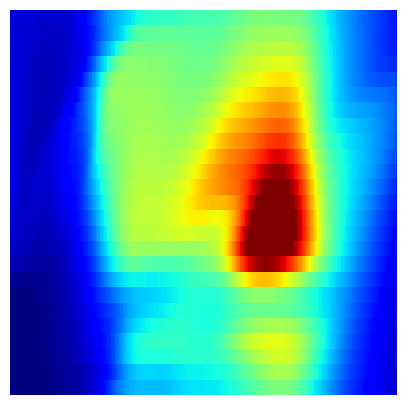

In [126]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(occupancy_recon_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/k_StudyFrame.png", dpi = 300)

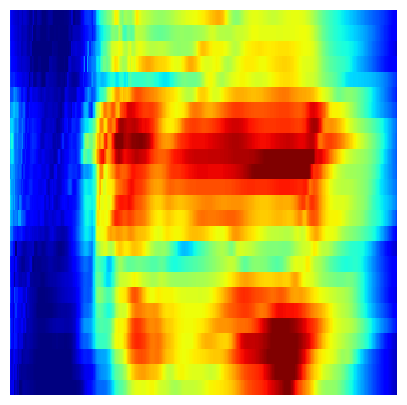

In [127]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(flow_recon_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/q_StudyFrame.png", dpi = 300)

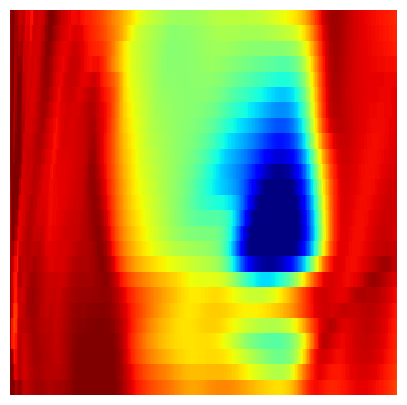

In [128]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(speed_recon_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/v_StudyFrame.png", dpi = 300)

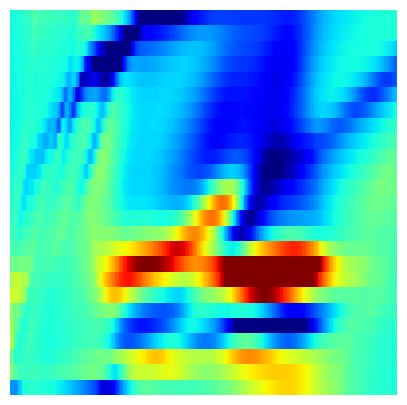

In [129]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(k_x_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/k_x_StudyFrame.png", dpi = 300)

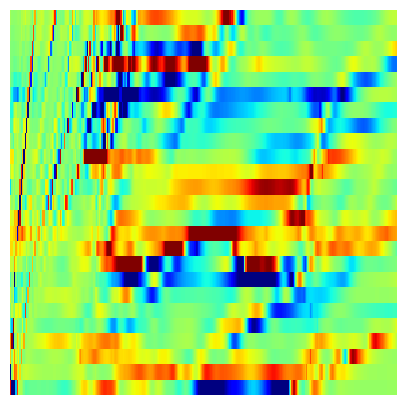

In [130]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(q_x_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/q_x_StudyFrame.png", dpi = 300)

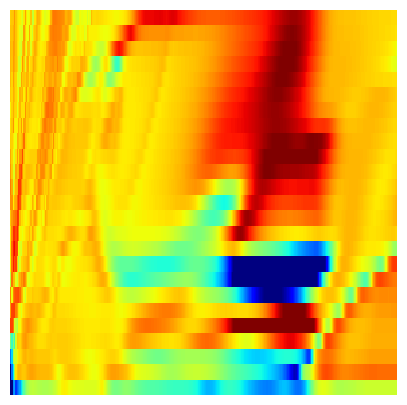

In [131]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(v_x_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/v_x_StudyFrame.png", dpi = 300)

In [132]:
k_xx['TimeStep'] = k_xx['TimeStep'].astype(int)
k_xx['Station_Number'] = k_xx['Station_Number'].astype(int)

q_xx['TimeStep'] = q_xx['TimeStep'].astype(int)
q_xx['Station_Number'] = q_xx['Station_Number'].astype(int)

v_xx['TimeStep'] = v_xx['TimeStep'].astype(int)
v_xx['Station_Number'] = v_xx['Station_Number'].astype(int)

In [133]:
k_xx_wide = k_xx.pivot(index='Station_Number', columns='TimeStep', values='k_xx')

q_xx_wide = q_xx.pivot(index='Station_Number', columns='TimeStep', values='q_xx')

v_xx_wide = v_xx.pivot(index='Station_Number', columns='TimeStep', values='v_xx')

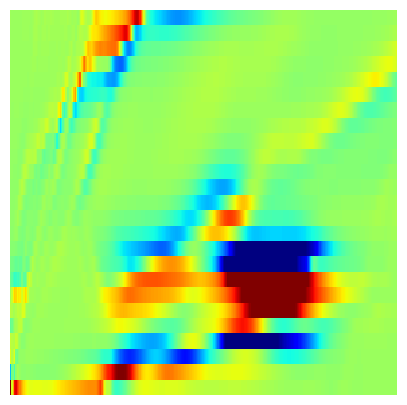

In [134]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(k_xx_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/k_xx_StudyFrame.png", dpi = 300)

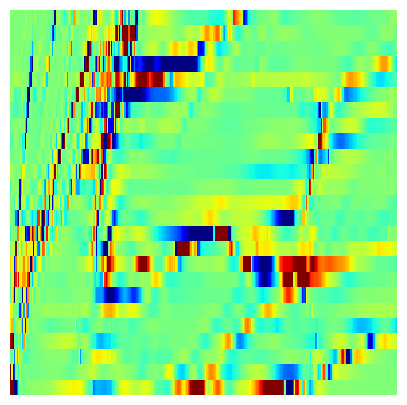

In [135]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(q_xx_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/q_xx_StudyFrame.png", dpi = 300)

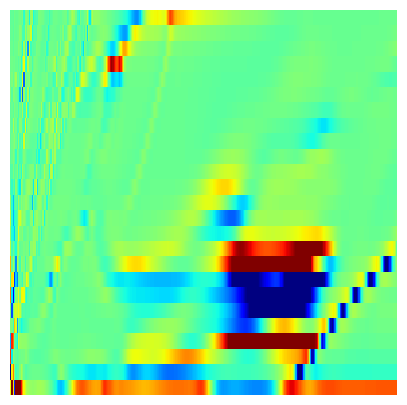

In [136]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(v_xx_wide.iloc[::-1], cmap="jet", annot=False,robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/v_xx_StudyFrame.png", dpi = 300)

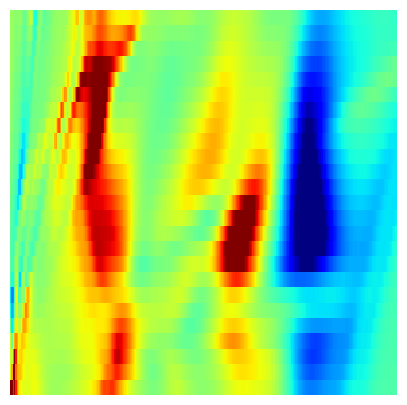

In [137]:
fig.savefig("Figures/Manuscript/q_xx_StudyFrame.png", dpi=300)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(k_t_wide.iloc[::-1], cmap="jet", annot=False, robust=True, ax=axs, cbar=False)
axs.set_xticks([])
axs.set_yticks([])
axs.set_xlabel("")
axs.set_ylabel("")
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Manuscript/k_t_StudyFrame.png", dpi=300)

## Training Progress Figure


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [12]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [13]:
pred_occu = pred['occupancy_recon'].to(torch.device('cpu'))
pred_flow = pred['flow_recon'].to(torch.device('cpu'))
pred_speed = pred['speed_recon'].to(torch.device('cpu'))

pred_k_t = pred['k_t'].to(torch.device('cpu'))
pred_k_t_predict = pred['k_t_predict'].to(torch.device('cpu'))

In [14]:
occupancy_recon = torch.cat((X_occu_all, pred_occu), dim=1).detach().numpy()
flow_recon = torch.cat((X_occu_all, pred_flow), dim=1).detach().numpy()
speed_recon = torch.cat((X_occu_all, pred_speed), dim=1).detach().numpy()
k_t = torch.cat((X_occu_all, pred_k_t), dim=1).detach().numpy()
k_t_predict = torch.cat((X_occu_all, pred_k_t_predict), dim=1).detach().numpy()

In [15]:
occupancy_recon = pd.DataFrame(occupancy_recon, columns = ['TimeStep','Station_Number','Occupancy'])
flow_recon = pd.DataFrame(flow_recon, columns = ['TimeStep','Station_Number','Flow'])
speed_recon = pd.DataFrame(speed_recon, columns = ['TimeStep','Station_Number','Speed'])

k_t = pd.DataFrame(k_t, columns = ['TimeStep','Station_Number','k_t'])
k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])

In [16]:
occupancy_recon['TimeStep'] = occupancy_recon['TimeStep'].astype(int)
occupancy_recon['Station_Number'] = occupancy_recon['Station_Number'].astype(int)
flow_recon['TimeStep'] = flow_recon['TimeStep'].astype(int)
flow_recon['Station_Number'] = flow_recon['Station_Number'].astype(int)
speed_recon['TimeStep'] = speed_recon['TimeStep'].astype(int)
speed_recon['Station_Number'] = speed_recon['Station_Number'].astype(int)

occupancy_recon_wide = occupancy_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
flow_recon_wide = flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Flow')
speed_recon_wide = speed_recon.pivot(index='Station_Number', columns='TimeStep', values='Speed')

In [17]:
# Load True Traffic data
Flow = pd.read_csv('Data_Clean/Flow_all.csv',index_col='Station_PM')
Occupancy = pd.read_csv('Data_Clean/Occupancy_all.csv',index_col='Station_PM')
Speed = pd.read_csv('Data_Clean/Speed_all.csv',index_col='Station_PM')

# Select the first 288 timestep
Occupancy = 100*Occupancy.iloc[:,72:216]
Flow = Flow.iloc[:,72:216]
Speed = Speed.iloc[:,72:216]

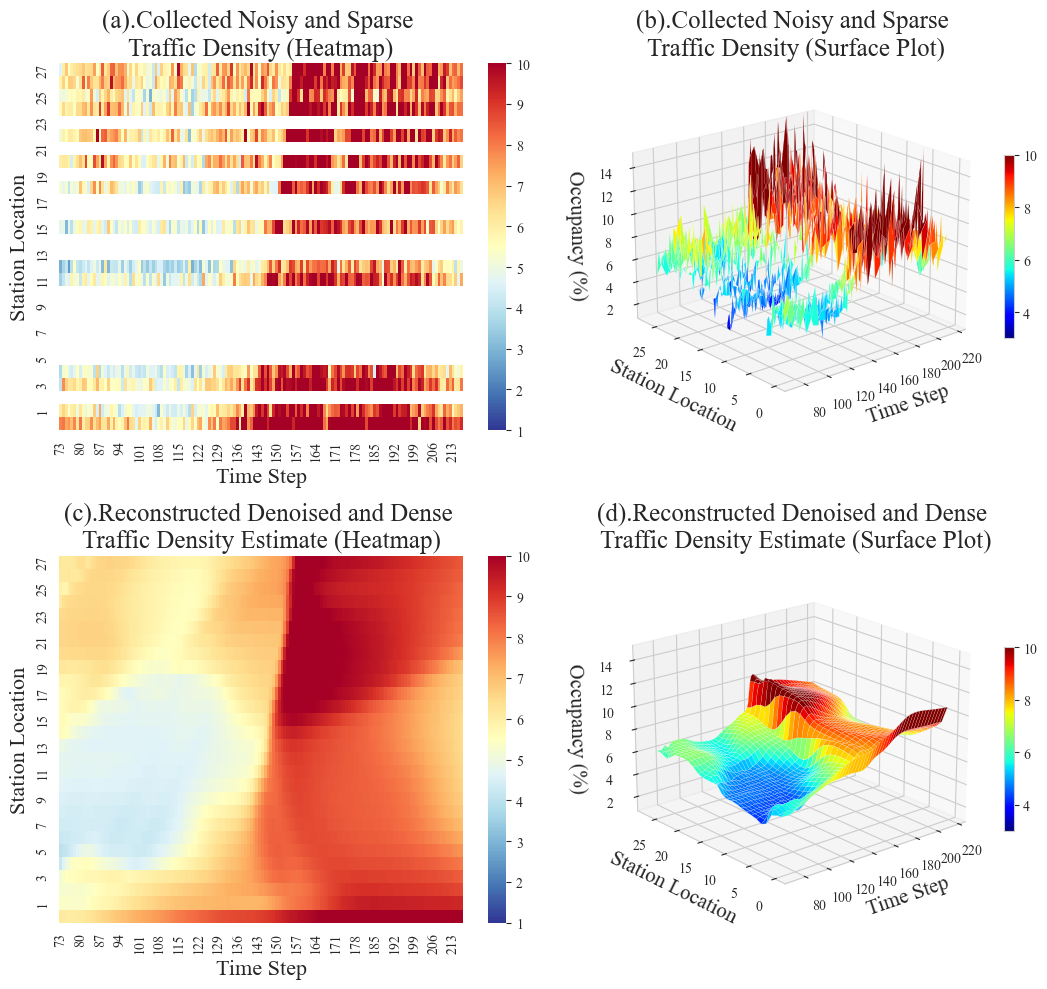

In [56]:
# Occupancy Reconstruction
fig = plt.figure(figsize=(11, 10))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(3, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T

ax1 = fig.add_subplot(222, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)
ax1.set_xlabel('Time Step', fontsize = 15)
ax1.set_ylabel('Station Location', fontsize = 15)
ax1.set_zlabel('Occupancy (%)', fontsize = 15)
ax1.set_title('(b).Collected Noisy and Sparse \nTraffic Density (Surface Plot)', fontsize = 18)

ax2 = fig.add_subplot(224, projection='3d')
surf2 = ax2.plot_surface(time, loc, occu_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax2.set_zlim(low_lim, up_lim)
ax2.view_init(elev=20, azim=230)
ax2.set_xlabel('Time Step', fontsize = 15)
ax2.set_ylabel('Station Location', fontsize = 15)
ax2.set_zlabel('Occupancy (%)', fontsize = 15)
ax2.set_title('(d).Reconstructed Denoised and Dense \nTraffic Density Estimate (Surface Plot)', fontsize = 18)

vmin1_occu, vmax1_occu = 1, 10

ax3 = fig.add_subplot(221)
sns.heatmap(Occupancy.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax3)
ax3.set_ylabel('Station Location', fontsize = 16)
ax3.set_xlabel('Time Step',  fontsize = 16)
ax3.set_title("(a).Collected Noisy and Sparse \nTraffic Density (Heatmap)",  fontsize = 18)


ax4 = fig.add_subplot(223)
sns.heatmap(occupancy_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax4)
ax4.set_ylabel('Station Location', fontsize = 16)
ax4.set_xlabel('Time Step',  fontsize = 16)
ax4.set_title("(c).Reconstructed Denoised and Dense \nTraffic Density Estimate (Heatmap)",  fontsize = 18)

fig.colorbar(surf1, ax=ax1, shrink=0.5)
fig.colorbar(surf2, ax=ax2, shrink=0.5)
plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()


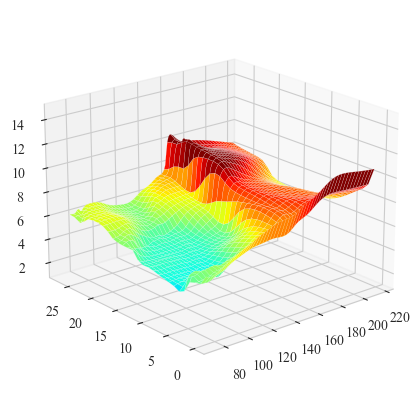

In [129]:
# Occupancy
fig = plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(1, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T


ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)

#ax1.axis('off')
fig.savefig("Figures/Manuscript/recon_final.png",bbox_inches='tight', dpi = 300, transparent=True)

In [130]:
occu_values_start = occu_values * 0

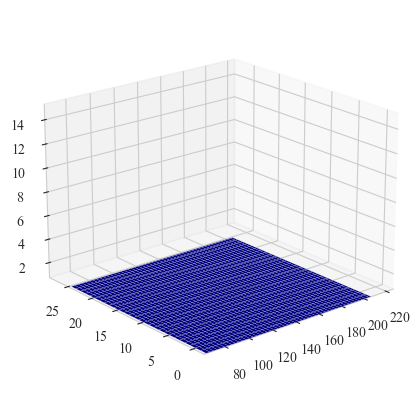

In [131]:
# Occupancy
fig = plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(3, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T


ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_values_start, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)

#ax1.axis('off')
fig.savefig("Figures/Manuscript/recon_start.png",bbox_inches='tight', dpi = 300, transparent=True)

In [132]:
occu_values_stage1 = 0.8 * occu_values_start + 0.2 * occu_values

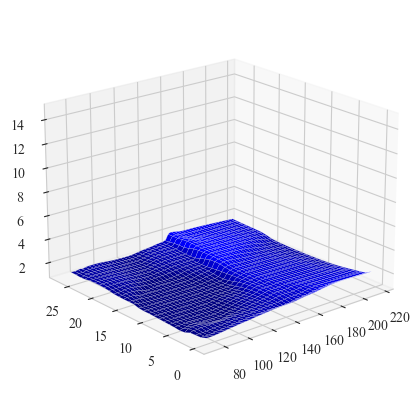

In [133]:
# Occupancy
fig = plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(1, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T


ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_values_stage1, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)

#ax1.axis('off')

fig.savefig("Figures/Manuscript/recon_stage1.png",bbox_inches='tight', dpi = 300, transparent=True)

In [134]:
occu_values_stage2 = 0.6 * occu_values_start + 0.4 * occu_values

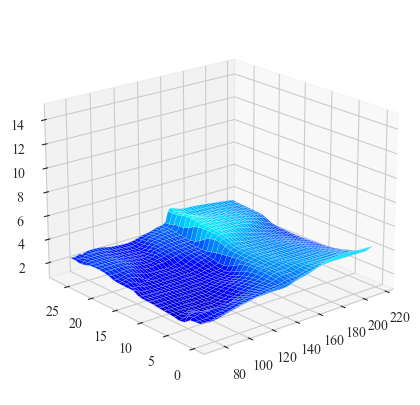

In [135]:
# Occupancy
fig = plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(1, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T


ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_values_stage2, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)

#ax1.axis('off')
fig.savefig("Figures/Manuscript/recon_stage2.png",bbox_inches='tight', dpi = 300, transparent=True)

In [136]:
occu_values_stage3 = 0.4 * occu_values_start + 0.6 * occu_values

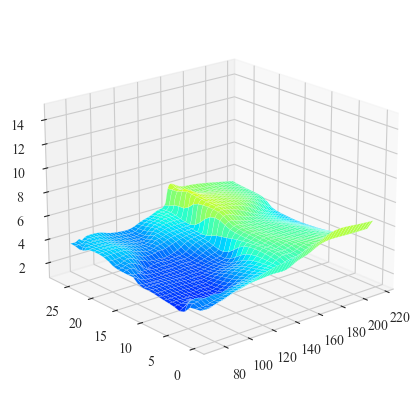

In [137]:
# Occupancy
fig = plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(1, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T


ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_values_stage3, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)

#ax1.axis('off')
fig.savefig("Figures/Manuscript/recon_stage3.png",bbox_inches='tight', dpi = 300, transparent=True)

In [138]:
occu_values_stage4 = 0.2 * occu_values_start + 0.8 * occu_values

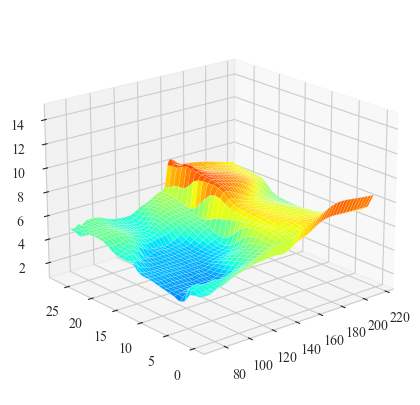

In [139]:
# Occupancy
fig = plt.figure(figsize=(5, 5))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(1, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T


ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_values_stage4, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)

#ax1.axis('off')
fig.savefig("Figures/Manuscript/recon_stage4.png",bbox_inches='tight', dpi = 300, transparent=True)